### Text Analysis of Rick and Morty TV show

Plot descriptions and dialogies transcripts downloaded from 
https://rickandmorty.fandom.com/wiki/Rickipedia



In [1]:
# scraping wikis
import requests
from bs4 import BeautifulSoup

# nltk
import nltk
nltk.download('stopwords')
from nltk.corpus import words
from nltk.stem import WordNetLemmatizer
from nltk import bigrams
from nltk.tokenize import RegexpTokenizer
# nltk.download()


# data wrangling
import pandas as pd
import numpy as np
import re
import math

# data visualisation
import matplotlib.pyplot as plt
from pandas.tools.plotting import parallel_coordinates
import seaborn as sns
sns.set_style('whitegrid')
from wordcloud import WordCloud
%matplotlib inline

import warnings 
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/dorotamierzwa/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Get episode titles

In [2]:
r = requests.get('https://rickandmorty.fandom.com/wiki/List_of_episodes')
html = r.text
soup = BeautifulSoup(html, "html5lib")

In [3]:
titles = []
for table_tag in soup.find_all('table'):
    for row in table_tag.find_all('tr'):
        links = row.find('a', href=re.compile("/wiki/"))
        if links: 
            title = links.get('title')
            titles.append(title)

In [4]:
titles

['Pilot',
 'Lawnmower Dog',
 'Anatomy Park (Episode)',
 'M. Night Shaym-Aliens!',
 'Meeseeks and Destroy',
 'Rick Potion 9',
 'Raising Gazorpazorp',
 'Rixty Minutes',
 'Something Ricked This Way Comes',
 'Close Rick-counters of the Rick Kind',
 'Ricksy Business',
 'A Rickle in Time',
 'Mortynight Run',
 'Auto Erotic Assimilation',
 'Total Rickall',
 'Get Schwifty',
 'The Ricks Must Be Crazy',
 'Big Trouble in Little Sanchez',
 'Interdimensional Cable 2: Tempting Fate',
 "Look Who's Purging Now",
 'The Wedding Squanchers',
 'The Rickshank Rickdemption',
 'Rickmancing the Stone',
 'Pickle Rick',
 'Vindicators 3: The Return of Worldender',
 'The Whirly Dirly Conspiracy',
 'Rest and Ricklaxation',
 'Tales From the Citadel',
 "Morty's Mind Blowers",
 "The ABC's of Beth",
 'The Rickchurian Mortydate',
 'Template:Episodes',
 'Season 1',
 'Season 2',
 'Season 3']

In [5]:
titles = titles[:-4]

In [6]:
df = pd.DataFrame(data=titles)

In [7]:
df.columns = ['title']

In [8]:
df['season'] = 1
df['season'].loc[11:21] = 2
df['season'].loc[21:] = 3

In [9]:
df.head()

,title,season
0,Pilot,1
1,Lawnmower Dog,1
2,Anatomy Park (Episode),1
3,M. Night Shaym-Aliens!,1
4,Meeseeks and Destroy,1


In [10]:
# create season-episode column
df['episode'] = 0
x = 1
y = 1
z = 1
for i in range(0, len(df)):
    if df['season'].loc[i] == 1:
        df['episode'].loc[i] = x
        x += 1
    if df['season'].loc[i] == 2:
        df['episode'].loc[i] = y
        y += 1
    if df['season'].loc[i] == 3:
        df['episode'].loc[i] = z
        z += 1

In [11]:
df['se'] = 's' + (df['season']).astype('str') + 'e' + (df['episode']).astype('str')

In [12]:
df.set_index('title', inplace=True)

In [13]:
df.head()

,season,episode,se
title,,,
Pilot,1,1,s1e1
Lawnmower Dog,1,2,s1e2
Anatomy Park (Episode),1,3,s1e3
M. Night Shaym-Aliens!,1,4,s1e4
Meeseeks and Destroy,1,5,s1e5


### Prepare nltk resources

In [14]:
# get English stopwords
sw = nltk.corpus.stopwords.words('english')
sw[:5]

['i', 'me', 'my', 'myself', 'we']

In [15]:
# set of English words
vocab = set(words.words())

In [16]:
# lemmatizer to group stem words
wordnet_lemmatizer = WordNetLemmatizer()

### Scraping functions

In [17]:
def get_plot_text(episode_title, sw):
    '''
    Get Rick and Morty episode plot description (between Plot and Characters heading) and remove stop words.
    
    Key words:
    episode_title  - string with episode title with capital letters
    sw - English stop words list
    '''
    
    plot = requests.get('https://rickandmorty.fandom.com/wiki/{}'.format(episode_title.replace(' ', '_')
                                                   .replace('\'', '%27')
                                                   .replace('Episode', 'episode'))).text
    soup = BeautifulSoup(plot, "html5lib")
    
    plot = soup.find(id="Plot")
    char = soup.find(id="Characters")
    
    plot_text = []
    for element in plot.next_elements:
        if element not in char.next_elements:
            if element not in soup.find_all('a'):
                if element not in soup.find_all('h2'):
                    if element not in soup.find_all('span'):
                        if element.string is not None:
                            if element.string not in plot_text:
                                plot_text.append(element.string)

    # create tokens
    tokenizer = RegexpTokenizer('\w+')
    tokens = tokenizer.tokenize(str(plot_text))

    # reomve stop words
    all_words = []
    for word in tokens:
        if word.lower() not in sw:
            all_words.append(word)
    
    return all_words

In [18]:
def get_character_verbs(episode_title, sw):
    '''
    Return bigrams that consist of character name and a verb
    
    Key words:
    episode_title  - string with episode title with capital letters
    sw - English stop words list
    '''
        
    all_words = get_plot_text(episode_title, sw)
    names = ['Rick', 'Morty', 'Jerry', 'Beth', 'Summer']
    bigrams_text = bigrams(all_words)
    character_bigrams = []
    for b in bigrams_text:
        if str(b[0]) in names:
            if not str(b[1])[0].isupper():
                if 'VB' in nltk.pos_tag([b[1]])[0][1]:
                    character_bigrams.append(b)
    return character_bigrams

In [19]:
# gather bigrams from all episodes
all_verb_bigrams = []
for episode in df.index:
    all_verb_bigrams.append(get_character_verbs(episode, sw))

In [20]:
all_verb_bigrams[:2]

[[('Beth', 'made'),
  ('Morty', 'accosted'),
  ('Morty', 'leave'),
  ('Beth', 'performing'),
  ('Morty', 'directing'),
  ('Rick', 'gives'),
  ('Morty', 'grappling'),
  ('Rick', 'neglected'),
  ('Jerry', 'trying'),
  ('Jerry', 'believes'),
  ('Morty', 'disappearing'),
  ('Beth', 'informed'),
  ('Morty', 'attended'),
  ('Morty', 'run'),
  ('Morty', 'learning'),
  ('Morty', 'amazing'),
  ('Morty', 'learning')],
 [('Rick', 'gives'),
  ('Morty', 'go'),
  ('Morty', 'assigned'),
  ('Morty', 'gives')]]

In [21]:
# flatten list of lists
all_verb_bigrams = [val for episode in all_verb_bigrams for val in episode]

In [22]:
all_verb_bigrams[:10]

[('Beth', 'made'),
 ('Morty', 'accosted'),
 ('Morty', 'leave'),
 ('Beth', 'performing'),
 ('Morty', 'directing'),
 ('Rick', 'gives'),
 ('Morty', 'grappling'),
 ('Rick', 'neglected'),
 ('Jerry', 'trying'),
 ('Jerry', 'believes')]

In [23]:
# group verbs of one character in a dictionary, append dictionary form of a verb
verb_dict = {}
for b in all_verb_bigrams:
    if b[0] not in verb_dict.keys():
        verb_dict[b[0]] = []
    else:
        verb_dict[b[0]].append(wordnet_lemmatizer.lemmatize(b[1], 'v'))

In [24]:
verb_dict['Beth'][:10]

['perform',
 'inform',
 'take',
 'call',
 'tell',
 'take',
 'take',
 'get',
 'move',
 'come']

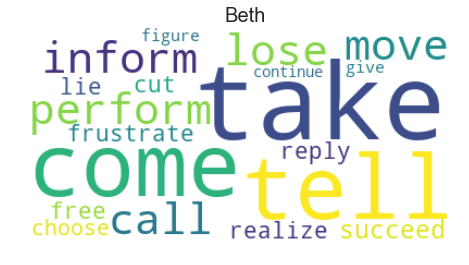

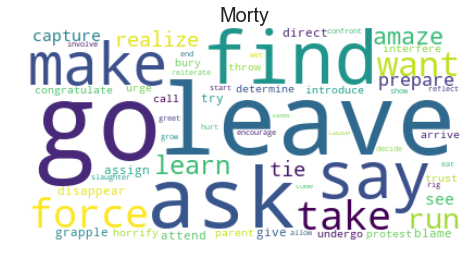

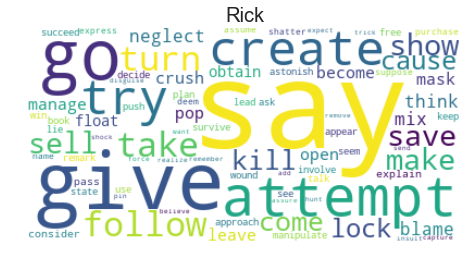

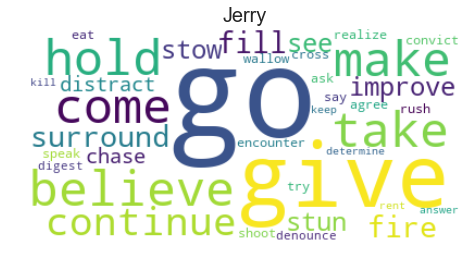

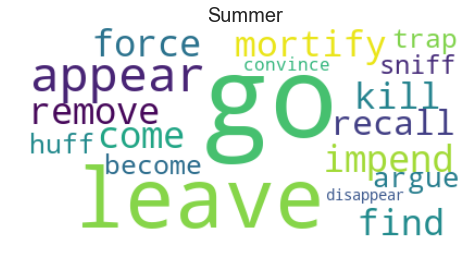

In [25]:
# generate world cloud of each character's verbs
for name in verb_dict.keys():
    verb_string = ''
    for word in verb_dict[name]:
        verb_string += word + ' '

    # Create and generate a word cloud image:
    fig, ax = plt.subplots(figsize=(8,4))
    wordcloud = WordCloud(background_color="white", prefer_horizontal=1).generate(verb_string)

    # Display the generated image:
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    ax.set_title(name, fontsize=20)

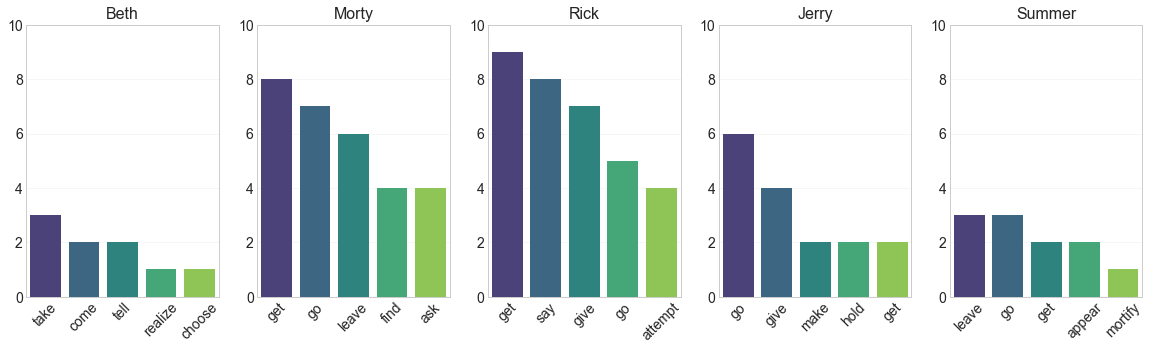

In [26]:
# plot absolute count of top 5 verbs per character
fig, axes = plt.subplots(ncols=5, nrows=1, figsize=(20,5))
ax = axes.flatten()
i = 0
for name in verb_dict.keys():
    word_freq = [(w, verb_dict[name].count(w)) for w in verb_dict[name]] 
    word_freq = list(set(word_freq))
    df2 = pd.DataFrame(word_freq)
    df2.sort_values(by=1, inplace=True, ascending=False)
    df2.reset_index(inplace=True)
    df2 = df2.iloc[:5]
    sns.barplot(x=0, y=1, data=df2, ax=ax[i], palette='viridis')
    ax[i].set_title(name, fontsize=16)
    ax[i].set_ylabel('')
    ax[i].set_xlabel('')
    for tick in ax[i].get_xticklabels():
        tick.set_rotation(45)
    ax[i].set_ylim(0, 10)
    ax[i].tick_params(top='off', bottom='off', left='off', right='off', labelleft='on', labelbottom='on',labelsize=14)
    ax[i].grid(axis='y', alpha=0.2)
    i += 1

 

In [27]:
df.index

Index(['Pilot', 'Lawnmower Dog', 'Anatomy Park (Episode)',
       'M. Night Shaym-Aliens!', 'Meeseeks and Destroy', 'Rick Potion 9',
       'Raising Gazorpazorp', 'Rixty Minutes',
       'Something Ricked This Way Comes',
       'Close Rick-counters of the Rick Kind', 'Ricksy Business',
       'A Rickle in Time', 'Mortynight Run', 'Auto Erotic Assimilation',
       'Total Rickall', 'Get Schwifty', 'The Ricks Must Be Crazy',
       'Big Trouble in Little Sanchez',
       'Interdimensional Cable 2: Tempting Fate', 'Look Who's Purging Now',
       'The Wedding Squanchers', 'The Rickshank Rickdemption',
       'Rickmancing the Stone', 'Pickle Rick',
       'Vindicators 3: The Return of Worldender',
       'The Whirly Dirly Conspiracy', 'Rest and Ricklaxation',
       'Tales From the Citadel', 'Morty's Mind Blowers', 'The ABC's of Beth',
       'The Rickchurian Mortydate'],
      dtype='object', name='title')

In [28]:
# gather plot text from all episodes (with the exception of names and some messy data)
all_episode_words = []
for episode in df.index:
    episode_string = get_plot_text(episode, sw)
    for word in episode_string:
        if word not in ['Rick', 'Morty', 'Jerry', 'Summer', 'Beth', 'n', 'Plot', 'Mr']:
            all_episode_words.append(word)

In [29]:
# extract word's part-of-speech
all_episode_nouns = [(n, nltk.pos_tag([n])[0][1]) for n in all_episode_words]

In [30]:
all_episode_nouns[:10]

[('middle', 'NN'),
 ('night', 'NN'),
 ('obviously', 'RB'),
 ('drunk', 'NN'),
 ('bursts', 'NNS'),
 ('room', 'NN'),
 ('tells', 'NNS'),
 ('surprise', 'NN'),
 ('show', 'NN'),
 ('driving', 'VBG')]

In [31]:
# get dictionary form of only nouns
all_episode_nouns2 = [wordnet_lemmatizer.lemmatize(n[0], 'v') for n in all_episode_nouns if 'NN' in n[1]]

In [32]:
all_episode_nouns2[:10]

['middle',
 'night',
 'drink',
 'burst',
 'room',
 'tell',
 'surprise',
 'show',
 'build',
 'vehicle']

In [33]:
# calculate nouns frequency
word_freq = [(w, all_episode_nouns2.count(w)) for w in all_episode_nouns2]

In [34]:
word_freq = list(set(word_freq))
df2 = pd.DataFrame(word_freq)

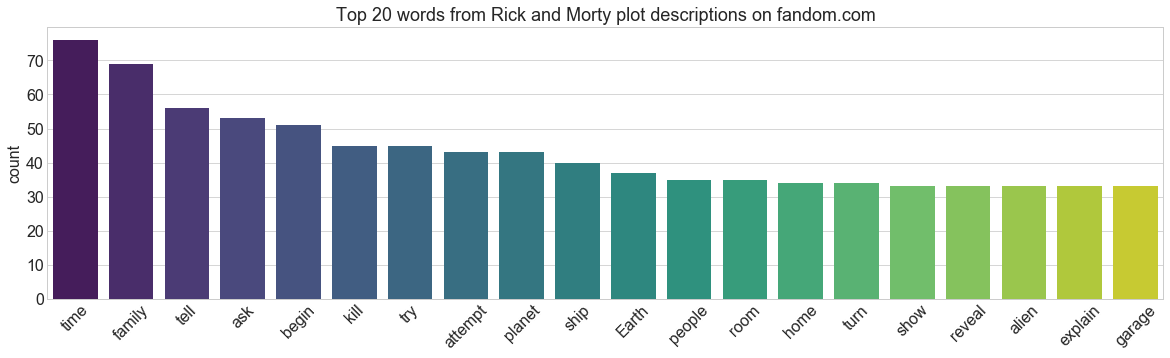

In [35]:
fig, ax = plt.subplots(figsize=(20,5))
df2.sort_values(by=1, inplace=True, ascending=False)
df2.reset_index(inplace=True)
df2 = df2.iloc[:20]
sns.barplot(x=0, y=1, data=df2, palette='viridis')
for tick in ax.get_xticklabels():
    tick.set_rotation(45)
    tick.set_fontsize(16)
for tick in ax.get_yticklabels():
    tick.set_fontsize(16)
ax.set_ylim(0)
ax.set_ylabel('count', fontsize=16)
ax.set_xlabel('')
ax.set_title('Top 20 words from Rick and Morty plot descriptions on fandom.com', fontsize=18);

### Get episode transcripts

In [36]:
def get_transcript(episode_title, sw):
    '''
    Get Rick and Morty transcript of dialogue in an episode and remove stop words.
    
    Key words:
    episode_title  - string with episode title with capital letters
    sw - English stop words list
    '''
    transcript = requests.get('https://rickandmorty.fandom.com/wiki/{}/Transcript'.format(episode_title.replace(' ', '_')
                                                   .replace('\'', '%27')
                                                   .replace('Episode', 'episode'))).text
    soup = BeautifulSoup(transcript, "html5lib")
    
    # get contents of p tags and clear unwanteg tags
    p_tags2 = soup.find_all("p")
    for tag in p_tags2:
        if tag.a is not None:
            tag.a.decompose()
        if tag.b is not None:
            tag.b.decompose()
        if tag.i is not None:
            tag.i.decompose()
            
    p_text = []
    for p in p_tags2:
        p_text.append(re.sub('\w+:', '', p.text)) # regex for removing names of people speaking
    p_text_cleaned = [re.findall('[a-zA-Z]+', p) for p in p_text] # remove non alphabetical characters
    p_text_cleaned2 = [y for x in p_text_cleaned for y in x] # turn list of lists to a single list

    # remove stop words
    final = []
    for word in p_text_cleaned2:
        if word.lower() not in sw:
            final.append(word)

    return final

In [37]:
# gather plot text from all transcripts (with the exception of names and some messy data)
all_dialogues_words = []
for episode in df.index:
    episode_dialogue = get_transcript(episode, sw)
    for word in episode_dialogue:
        if word not in ['Rick', 'Morty', 'Jerry', 'Summer', 'Beth', 'Trans', 'Oh', 'Yeah', 'Mr', 'Hey']:
            all_dialogues_words.append(word)

In [38]:
all_dialogues_nouns = [(n, nltk.pos_tag([n])[0][1]) for n in all_dialogues_words]

In [39]:
all_dialogues_nouns2 = [wordnet_lemmatizer.lemmatize(n[0], 'v') for n in all_dialogues_nouns if 'NN' in n[1]]

In [40]:
word_freq2 = [(w, all_episode_words.count(w)) for w in all_dialogues_nouns2]

In [41]:
word_freq2 = list(set(word_freq2))
df4 = pd.DataFrame(word_freq2)

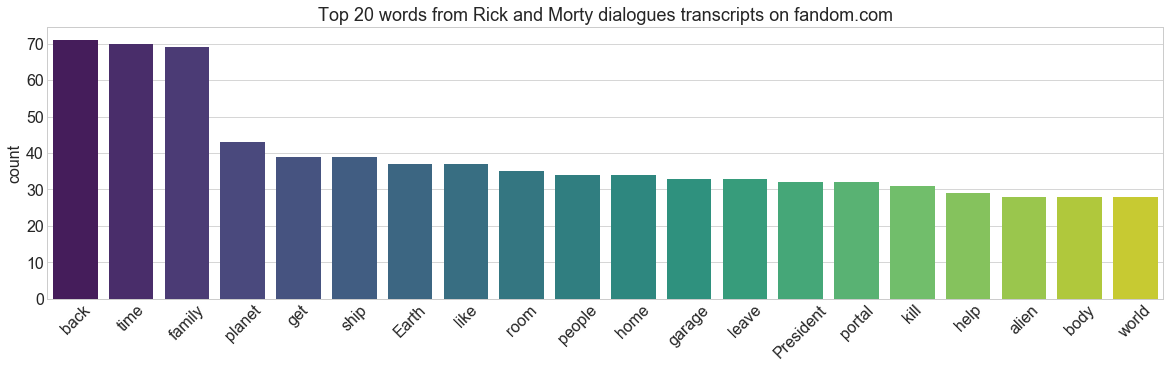

In [42]:
fig, ax = plt.subplots(figsize=(20,5))
df4.sort_values(by=1, inplace=True, ascending=False)
df4.reset_index(inplace=True)
df4 = df4.iloc[:20]
sns.barplot(x=0, y=1, data=df4, palette='viridis')
for tick in ax.get_xticklabels():
    tick.set_rotation(45)
    tick.set_fontsize(16)
for tick in ax.get_yticklabels():
    tick.set_fontsize(16)
ax.set_ylim(0)
ax.set_ylabel('count', fontsize=16)
ax.set_xlabel('')
ax.set_title('Top 20 words from Rick and Morty dialogues transcripts on fandom.com', fontsize=18);

In [43]:
# prepare data for comparison plot
df2 = df2.loc[:20]
df2.drop('index', inplace=True, axis=1)
df2.columns = ['plot_word', 'plot_count']

df4 = df4.loc[:20]
df4.drop('index', inplace=True, axis=1)
df4.columns = ['dialogue_word', 'dialogue_count']


In [44]:
joined = df2.set_index('plot_word').join(df4.set_index('dialogue_word'), how='outer')

In [45]:
joined.fillna(0, inplace=True)
joined.head()

,plot_count,dialogue_count
Earth,37.0,37.0
President,0.0,32.0
alien,33.0,28.0
ask,53.0,0.0
attempt,43.0,0.0


In [46]:
joined.reset_index(inplace=True)

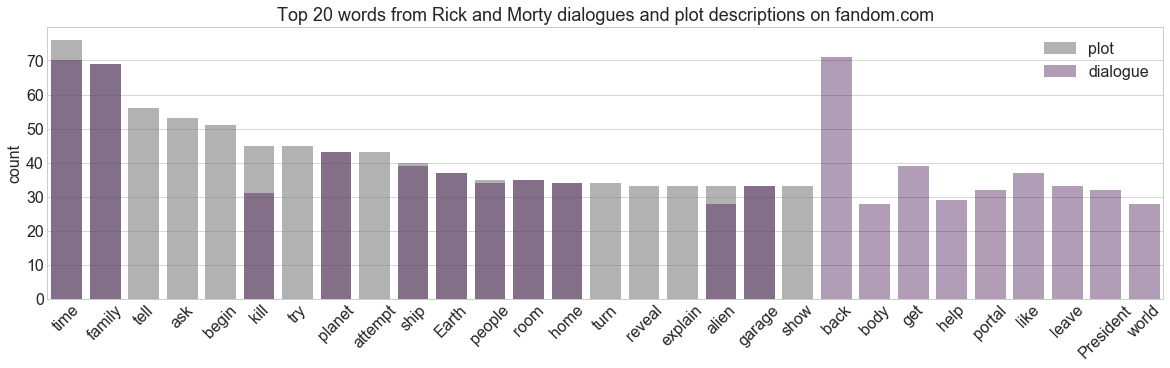

In [47]:
fig, ax = plt.subplots(figsize=(20,5))
joined.sort_values(by=['plot_count'], inplace=True, ascending=False)
sns.barplot(x=joined['index'], y=joined['plot_count'], color='grey', alpha=0.6, label='plot')
sns.barplot(x=joined['index'], y=joined['dialogue_count'], color='#440154FF', alpha=0.4, label='dialogue')
ax.legend(frameon=False, fontsize=16)
for tick in ax.get_xticklabels():
    tick.set_rotation(45)
    tick.set_fontsize(16)
for tick in ax.get_yticklabels():
    tick.set_fontsize(16)
ax.set_ylim(0)
ax.set_ylabel('count', fontsize=16)
ax.set_xlabel('')
ax.set_title('Top 20 words from Rick and Morty dialogues and plot descriptions on fandom.com', fontsize=18);

In [48]:
# calculate dialogues length for each episode
df['dialogues_length'] = ''
for episode in df.index:
    transcript = get_transcript(episode, sw)
    if len(transcript) > 1:
        df['dialogues_length'].loc[episode] = len(transcript)
    else:
        df['dialogues_length'].loc[episode] = '-'

In [49]:
df

,season,episode,se,dialogues_length
title,,,,
Pilot,1,1,s1e1,2658
Lawnmower Dog,1,2,s1e2,2404
Anatomy Park (Episode),1,3,s1e3,3109
M. Night Shaym-Aliens!,1,4,s1e4,1932
Meeseeks and Destroy,1,5,s1e5,2161
Rick Potion 9,1,6,s1e6,967
Raising Gazorpazorp,1,7,s1e7,1765
Rixty Minutes,1,8,s1e8,650
Something Ricked This Way Comes,1,9,s1e9,2486


In [50]:
# remove incomplete transcripts
df = df[(df['dialogues_length'] != '-')]
df = df[df['dialogues_length'] > 500]
df['dialogues_length'] = df['dialogues_length'].astype('int')

In [51]:
df['dialogues_length'].mean()

2315.7619047619046

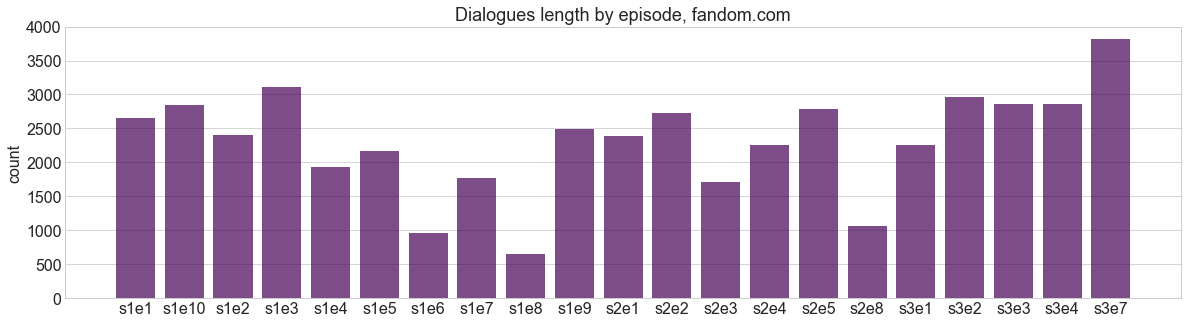

In [52]:
fig, ax = plt.subplots(figsize=(20,5))
plt.bar(x=df['se'], height=df['dialogues_length'].astype('int'), color='#440154FF', alpha=0.7)
ax.set_ylim(0)
ax.set_ylabel('count', fontsize=16)
for tick in ax.get_xticklabels():
    tick.set_fontsize(16)
for tick in ax.get_yticklabels():
    tick.set_fontsize(16)
ax.grid(axis='x', alpha=0)
ax.set_title('Dialogues length by episode, fandom.com', fontsize=18);

In [53]:
df.head()

,season,episode,se,dialogues_length
title,,,,
Pilot,1,1,s1e1,2658
Lawnmower Dog,1,2,s1e2,2404
Anatomy Park (Episode),1,3,s1e3,3109
M. Night Shaym-Aliens!,1,4,s1e4,1932
Meeseeks and Destroy,1,5,s1e5,2161


In [54]:
# calculate "geez" frequence
df['geez_freq'] = ''
for episode in df.index:
    transcript = get_transcript(episode, sw)
    if len(transcript) > 1:
        freqdist = nltk.FreqDist(transcript)
        df['geez_freq'].loc[episode] = freqdist['Geez'] + freqdist['geez']

In [55]:
df

,season,episode,se,dialogues_length,geez_freq
title,,,,,
Pilot,1,1,s1e1,2658,8
Lawnmower Dog,1,2,s1e2,2404,5
Anatomy Park (Episode),1,3,s1e3,3109,2
M. Night Shaym-Aliens!,1,4,s1e4,1932,3
Meeseeks and Destroy,1,5,s1e5,2161,0
Rick Potion 9,1,6,s1e6,967,0
Raising Gazorpazorp,1,7,s1e7,1765,0
Rixty Minutes,1,8,s1e8,650,0
Something Ricked This Way Comes,1,9,s1e9,2486,1


In [56]:
for col in df.columns[3:]:
    df[col] = df[col].astype('int')

In [57]:
df.sort_values(by=['season', 'episode'], inplace=True)

In [58]:
df['se'].values

array(['s1e1', 's1e2', 's1e3', 's1e4', 's1e5', 's1e6', 's1e7', 's1e8',
       's1e9', 's1e10', 's2e1', 's2e2', 's2e3', 's2e4', 's2e5', 's2e8',
       's3e1', 's3e2', 's3e3', 's3e4', 's3e7'], dtype=object)

In [59]:
df.reset_index(inplace=True)

In [60]:
df.tail()

,title,season,episode,se,dialogues_length,geez_freq
16,The Rickshank Rickdemption,3,1,s3e1,2251,2
17,Rickmancing the Stone,3,2,s3e2,2964,4
18,Pickle Rick,3,3,s3e3,2855,3
19,Vindicators 3: The Return of Worldender,3,4,s3e4,2859,1
20,Tales From the Citadel,3,7,s3e7,3810,11


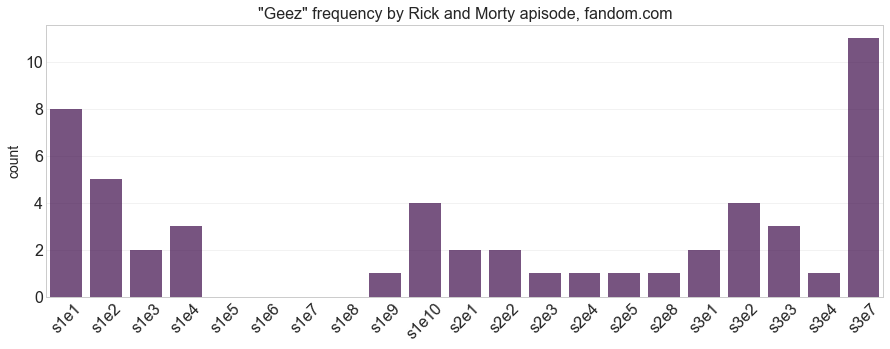

In [61]:
fig, ax = plt.subplots(figsize=(15,5))
sns.barplot(x=df['se'], y=df['geez_freq'], color='#440154FF', alpha=0.7)
ax.set_xlabel('')
ax.grid(axis='y', alpha=0.3)
ax.grid(axis='x', alpha=0)
ax.set_ylim(0)
ax.set_ylabel('count', fontsize=14)
for tick in ax.get_xticklabels():
    tick.set_rotation(45)
    tick.set_fontsize(16)
for tick in ax.get_yticklabels():
    tick.set_fontsize(16)
ax.set_title('"Geez" frequency by Rick and Morty apisode, fandom.com', fontsize=16);

In [62]:
print(str(df['geez_freq'].sum()))

52


In [63]:
df['geez_freq'].mean()

2.4761904761904763